In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import scipy.linalg as spla
import jaxgptoolbox as jgp
import polyscope as ps
from plotnine import *
import polars as pl
import itertools
import sklearn as skl

In [2]:
NUM_VERTICES = 12500
NUM_DATA = 3048

In [3]:
df_ad = pl.read_csv("data/curvature_smoothed.csv")
df_ad

id,gender,ad_v_0,ad_v_1,ad_v_2,ad_v_3,ad_v_4,ad_v_5,ad_v_6,ad_v_7,ad_v_8,ad_v_9,ad_v_10,ad_v_11,ad_v_12,ad_v_13,ad_v_14,ad_v_15,ad_v_16,ad_v_17,ad_v_18,ad_v_19,ad_v_20,ad_v_21,ad_v_22,ad_v_23,ad_v_24,ad_v_25,ad_v_26,ad_v_27,ad_v_28,ad_v_29,ad_v_30,ad_v_31,ad_v_32,ad_v_33,ad_v_34,…,ad_v_12463,ad_v_12464,ad_v_12465,ad_v_12466,ad_v_12467,ad_v_12468,ad_v_12469,ad_v_12470,ad_v_12471,ad_v_12472,ad_v_12473,ad_v_12474,ad_v_12475,ad_v_12476,ad_v_12477,ad_v_12478,ad_v_12479,ad_v_12480,ad_v_12481,ad_v_12482,ad_v_12483,ad_v_12484,ad_v_12485,ad_v_12486,ad_v_12487,ad_v_12488,ad_v_12489,ad_v_12490,ad_v_12491,ad_v_12492,ad_v_12493,ad_v_12494,ad_v_12495,ad_v_12496,ad_v_12497,ad_v_12498,ad_v_12499
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""F1994""","""F""",0.000494,0.001285,0.000783,-0.000816,-0.000033,0.000857,0.001172,0.00182,0.001967,-0.000501,0.001106,-0.000833,0.002117,0.000411,0.003223,0.006052,-0.000459,0.006823,0.000327,0.007649,0.009134,-0.000077,0.002076,0.005887,0.001196,0.00641,0.002454,-0.001018,0.000524,-0.001092,0.002018,-0.003896,0.025157,0.020118,0.013667,…,0.015304,0.011773,0.042524,0.00107,0.008645,-0.000071,0.001915,0.0051651,0.005334,0.02335,0.022159,0.00313,0.001887,0.01302,0.011207,0.006168,0.035982,0.009065,0.000984,0.044866,-0.000804,-0.07646,-0.005487,-0.005998,-0.008928,-0.043915,-0.07673,-0.024228,-0.013135,-0.068809,-0.059373,-0.098887,-0.126286,-0.483917,-0.143424,-0.261326,-0.000583
"""F4668""","""F""",0.000415,0.0013,0.000571,-0.001068,0.000148,0.000795,0.001914,0.001592,0.003474,0.000149,0.000817,-0.00223,0.001932,0.000235,0.003036,0.004112,-0.001884,0.005686,-0.000436,0.010021,0.008619,-0.001015,0.002221,0.004869,-0.002015,0.000603,-0.00088,-0.001704,-0.001142,-0.001405,0.005174,-0.002971,0.029147,0.025352,0.017979,…,0.013303,0.012698,0.044112,0.00063,0.010657,-0.000239,0.002444,0.008269,0.004255,0.018548,0.017653,0.005504,0.003153,0.013499,0.012027,0.005791,0.031241,0.0114007,0.001238,0.039516,-0.006747,-0.116604,-0.009284,-0.007119,-0.006025,-0.025247,-0.091053,-0.027527,-0.0106,-0.055003,-0.042159,-0.055464,-0.08196,-0.305417,-0.118357,-0.171688,-0.024287
"""F4761""","""F""",0.000127,0.000681,0.0004,-0.001279,-0.000475,0.000309,0.000612,0.001133,0.001809,-0.000593,0.000077,-0.003656,-0.000021,0.00011,0.00256,0.004739,-0.002095,0.00637,-0.00055,0.007938,0.007973,-0.000603,0.001706,0.005141,-0.000294,0.00348,0.00001,-0.002624,-0.000482,-0.002778,0.003257,-0.005248,0.023129,0.022382,0.015973,…,0.013697,0.014354,0.050835,-0.001293,0.015072,0.000451,0.002916,0.009363,0.001718,0.014519,0.021168,0.007896,0.004148,0.015437,0.014143,0.001806,0.02568,0.013291,0.000904,0.050478,-0.003723,-0.101465,-0.008218,-0.007349,-0.007642,-0.050641,-0.08894,-0.026507,-0.010362,-0.057054,-0.052852,-0.087103,-0.091732,-0.341567,-0.138283,-0.189049,-0.015246
"""F1207""","""F""",0.000432,0.000446,-0.000449,-0.000062,0.000294,-0.001595,0.00039,0.000904,0.003019,-0.001113,0.000609,-0.001666,0.001614,-0.002167,0.001598,0.000214,-0.009565,0.000705,-0.003224,0.005789,0.004276,-0.000353,0.000484,0.00551,-0.004828,-0.000196,-0.002412,-0.001102,-0.00395,-0.00327,0.005763,-0.004667,0.016556,0.014781,0.010383,…,0.016882,0.016694,0.058915,0.001796,0.01232,-0.00006,0.002665,0.011149,-0.000103,0.016478,0.009685,0.0066,0.003678,0.009306,0.012602,0.004186,0.022358,0.012386,0.000231,0.027203,-0.010095,-0.110969,-0.014137,0.025943,0.000776,-0.028537,0.022605,-0.084574,-0.065061,-0.306666,-0.20088,-0.122372,-0.10878,-0.561398,-0.22995,-0.59653,0.0342288
"""F0189""","""F""",0.000498,0.000687,-0.000057,-0.000319,0.000171,0.000304,0.001657,0.00151,0.00285,0.000256,0.000317,-0.002988,0.001164,-0.001046,0.003466,0.006325,-0.002229,0.007303,0.000313,0.011217,0.010133,-0.000234,0.001251,0.007231,-0.000965,

In [4]:
key = jax.random.PRNGKey(seed=42)

permutation = np.array(jax.random.permutation(key, NUM_DATA))
permutation

array([1739, 1727, 1836, ..., 1143,  565,  710], dtype=int32)

In [5]:
def data_split(X,y, permutation):
    y_ = np.take(y, permutation, axis=0)
    X_ = np.take(X, permutation, axis=0)

    y_train = y_[0:2500]
    y_test = y_[2500:]
    X_train = X_[0:2500,:]
    X_test = X_[2500:,:]

    return X_train, X_test, y_train, y_test

In [6]:
gender = df_ad[:,"gender"].to_numpy()
angle_defect_matrix = df_ad.select(df_ad.columns[2:(NUM_VERTICES+2)]).to_numpy()

gender_to_int = {'F':0, 'M':1}

y = [gender_to_int[i] for i in gender]

X_train, X_test, y_train, y_test = data_split(angle_defect_matrix, y, permutation)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2500, 12500), (548, 12500), (2500,), (548,))

In [8]:
U, S, Vt = np.linalg.svd(angle_defect_matrix)

In [9]:
explained_variance = (S**2) / (S**2).sum()
cumulative_variance = np.cumsum(explained_variance)
component = np.arange(1,len(S)+1)

In [10]:
PC1 = U[:,0] * S[0]
PC2 = U[:,1] * S[1]
PC3 = U[:,2] * S[2]
PC4 = U[:,3] * S[3]

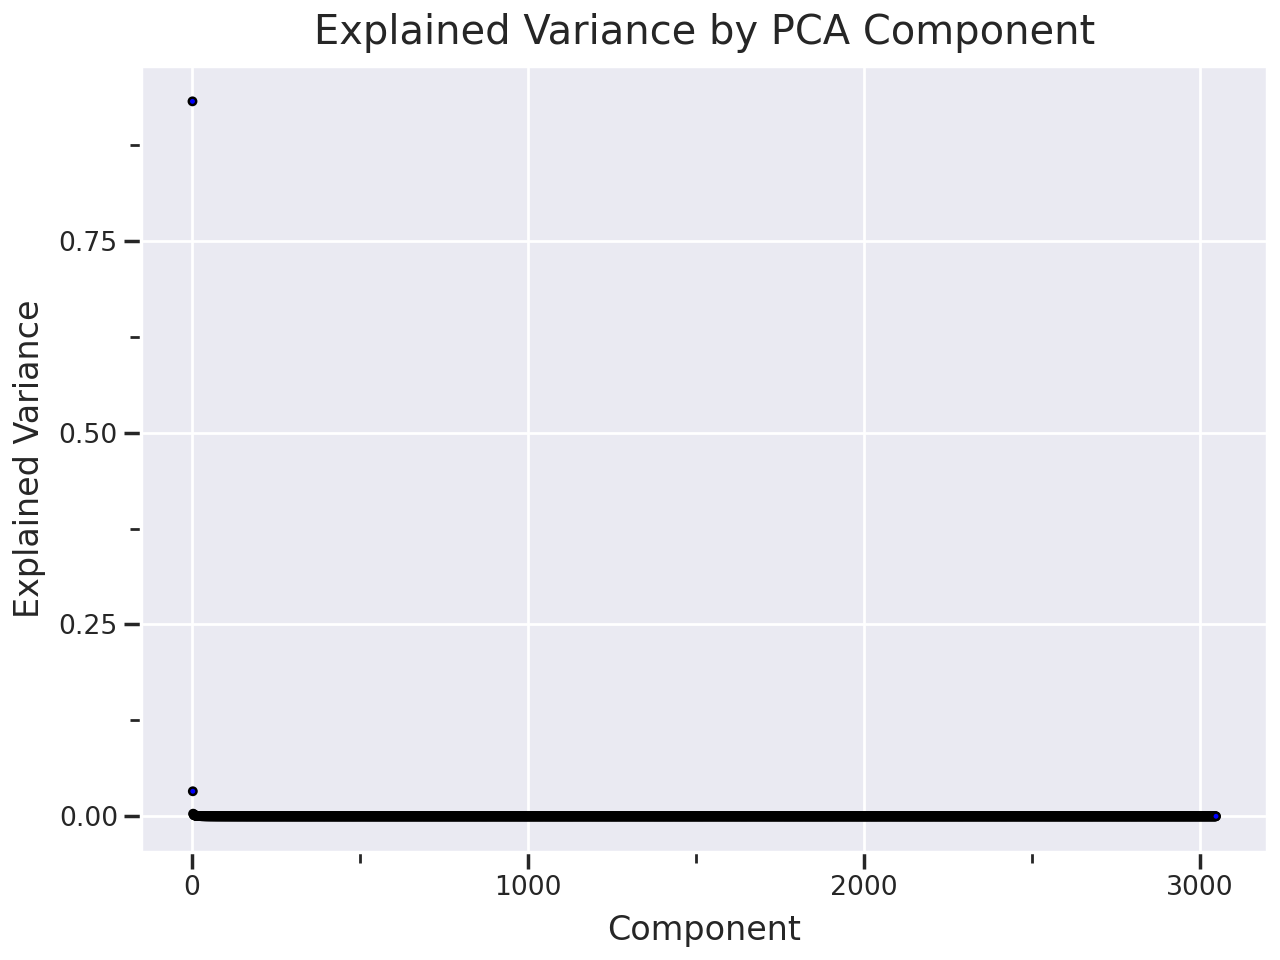

In [12]:
plot_pcavar = (
    ggplot() +
    geom_point(aes(x=component, y=explained_variance), fill='blue', size=1) +
    #geom_line(aes(x='Component', y='ExplainedVariance'), fill='blue') +
    labs(title='Explained Variance by PCA Component',
        x='Component',
        y = 'Explained Variance'
    ) +
    theme_seaborn()
    #scale_x_continuous(breaks=range(1,min(21,len(S)+1), 2))
)
plot_pcavar

In [13]:
plot_pcavar.save("plots/pca_variance.pdf")

/home/csimal/Documents/Projects/SIGBOVIK/gender-geometry/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/csimal/Documents/Projects/SIGBOVIK/gender-geometry/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/pca_variance.pdf


/home/csimal/Documents/Projects/SIGBOVIK/gender-geometry/.venv/lib/python3.10/site-packages/plotnine/guides/guides.py:211: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


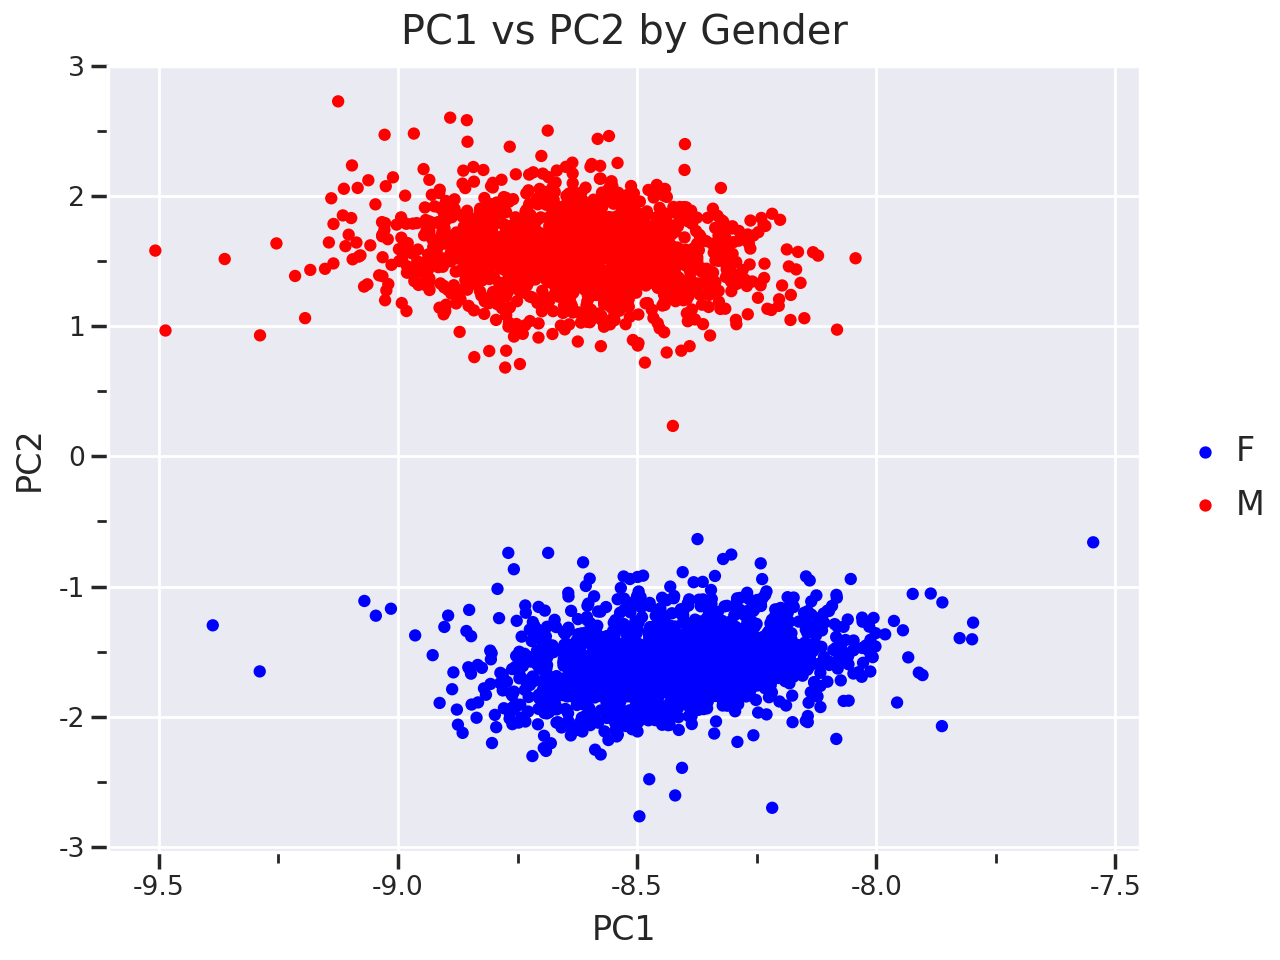

In [14]:
plot_pca_components = (
    ggplot() +
    geom_point(aes(x=PC1,y=PC2, color=gender)) +
    labs(title="PC1 vs PC2 by Gender",
        x = 'PC1',
        y = 'PC2'
    ) +
    theme_seaborn() +
    scale_color_manual(values=['blue','red'])
)
plot_pca_components

In [16]:
plot_pca_components.save("plots/pca_components.pdf")

/home/csimal/Documents/Projects/SIGBOVIK/gender-geometry/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/csimal/Documents/Projects/SIGBOVIK/gender-geometry/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/pca_components.pdf
/home/csimal/Documents/Projects/SIGBOVIK/gender-geometry/.venv/lib/python3.10/site-packages/plotnine/guides/guides.py:211: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


In [17]:
pc2_verts = Vt[1,:]

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

LR = LogisticRegression()

LR.fit(X_train, y_train)

LR.score(X_train, y_train), LR.score(X_test, y_test)

(1.0, 1.0)

In [19]:
lr_coef = LR.coef_.flatten()

In [3]:
v, f = jgp.read_mesh("mean_human_body.obj")

In [4]:
len(f)

25000

In [41]:
ps.init()
mesh = ps.register_surface_mesh('mean human body', v, f)
mesh.add_scalar_quantity('PC2', pc2_verts)
mesh.add_scalar_quantity('LR coefficients', lr_coef)
ps.show()

In [23]:
np.dot(pc2_verts, lr_coef) / (np.linalg.norm(pc2_verts) * np.linalg.norm(lr_coef))

0.9903767092164596

In [6]:
df_tda = pl.read_csv("data/persistence_smoothed.csv")
df_tda

id,gender,p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,p_11,p_12,p_13,p_14,p_15,p_16,p_17,p_18,p_19,p_20,p_21,p_22,p_23,p_24,p_25,p_26,p_27,p_28,p_29,p_30,p_31,p_32,p_33,p_34,…,p_428,p_429,p_430,p_431,p_432,p_433,p_434,p_435,p_436,p_437,p_438,p_439,p_440,p_441,p_442,p_443,p_444,p_445,p_446,p_447,p_448,p_449,p_450,p_451,p_452,p_453,p_454,p_455,p_456,p_457,p_458,p_459,p_460,p_461,p_462,p_463,p_464
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""F1994""","""F""",0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,…,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012
"""F4668""","""F""",0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,…,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012
"""F4761""","""F""",0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,…,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012
"""F1207""","""F""",0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,…,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012
"""F0189""","""F""",0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,…,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.00001

In [7]:
persistence_matrix = df_tda.select(df_tda.columns[2:467]).to_numpy()
persistence_matrix.shape

(3048, 465)

In [8]:
np.linalg.matrix_rank(persistence_matrix)

1

In [28]:
X_train_tda, X_test_tda, y_train, y_test = data_split(persistence_matrix, y, permutation)
X_train_tda.shape, X_test_tda.shape, y_train.shape, y_test.shape

((2500, 465), (548, 465), (2500,), (548,))

In [30]:
LR_tda = LogisticRegression()

LR_tda.fit(X_train_tda, y_train)

LR_tda.score(X_train_tda, y_train), LR_tda.score(X_test_tda, y_test)

(0.5008, 0.5091240875912408)

In [31]:
df_coords = pl.read_csv("data/coords_smoothed.csv")
df_coords

id,gender,v_0_x,v_0_y,v_0_z,v_1_x,v_1_y,v_1_z,v_2_x,v_2_y,v_2_z,v_3_x,v_3_y,v_3_z,v_4_x,v_4_y,v_4_z,v_5_x,v_5_y,v_5_z,v_6_x,v_6_y,v_6_z,v_7_x,v_7_y,v_7_z,v_8_x,v_8_y,v_8_z,v_9_x,v_9_y,v_9_z,v_10_x,v_10_y,v_10_z,v_11_x,v_11_y,…,v_12487_z,v_12488_x,v_12488_y,v_12488_z,v_12489_x,v_12489_y,v_12489_z,v_12490_x,v_12490_y,v_12490_z,v_12491_x,v_12491_y,v_12491_z,v_12492_x,v_12492_y,v_12492_z,v_12493_x,v_12493_y,v_12493_z,v_12494_x,v_12494_y,v_12494_z,v_12495_x,v_12495_y,v_12495_z,v_12496_x,v_12496_y,v_12496_z,v_12497_x,v_12497_y,v_12497_z,v_12498_x,v_12498_y,v_12498_z,v_12499_x,v_12499_y,v_12499_z
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""F1994""","""F""",-0.027136,0.1851528,-0.993163,-0.019469,0.173407,-0.99622,-0.009937,0.18924,-0.993429,-0.037553,0.16634,-0.995577,-0.044077,0.182807,-0.992691,-0.001918,0.177351,-0.996391,-0.008265,0.164383,-0.998507,-0.016012,0.198658,-0.990726,-0.020815,0.160086,-0.998243,-0.030164,0.2000988,-0.989053,-0.054845,0.172102,-0.993878,-0.051291,0.192335,…,-0.280607,0.1493539,0.147871,-0.285177,0.162779,0.148808,-0.273566,0.061485,0.064668,-0.281098,0.070359,0.069008,-0.284098,0.080666,0.080428,-0.287025,0.092241,0.08526,-0.289527,0.158764,0.152544,-0.275878,0.155234,0.1472541,-0.278976,0.144618,0.137044,-0.286217,0.124298,0.107236,-0.293621,0.115651,0.109368,-0.291489,0.157608,0.141561,-0.278668
"""F4668""","""F""",-0.027136,0.1851528,-0.993163,-0.019469,0.173407,-0.99622,-0.009937,0.18924,-0.993429,-0.037553,0.16634,-0.995577,-0.044077,0.182807,-0.992691,-0.001918,0.177351,-0.996391,-0.008265,0.164383,-0.998507,-0.016012,0.198658,-0.990726,-0.020815,0.160086,-0.998243,-0.030164,0.2000988,-0.989053,-0.054845,0.172102,-0.993878,-0.051291,0.192335,…,-0.280607,0.1493539,0.147871,-0.285177,0.162779,0.148808,-0.273566,0.061485,0.064668,-0.281098,0.070359,0.069008,-0.284098,0.080666,0.080428,-0.287025,0.092241,0.08526,-0.289527,0.158764,0.152544,-0.275878,0.155234,0.1472541,-0.278976,0.144618,0.137044,-0.286217,0.124298,0.107236,-0.293621,0.115651,0.109368,-0.291489,0.157608,0.141561,-0.278668
"""F4761""","""F""",-0.027136,0.1851528,-0.993163,-0.019469,0.173407,-0.99622,-0.009937,0.18924,-0.993429,-0.037553,0.16634,-0.995577,-0.044077,0.182807,-0.992691,-0.001918,0.177351,-0.996391,-0.008265,0.164383,-0.998507,-0.016012,0.198658,-0.990726,-0.020815,0.160086,-0.998243,-0.030164,0.2000988,-0.989053,-0.054845,0.172102,-0.993878,-0.051291,0.192335,…,-0.280607,0.1493539,0.147871,-0.285177,0.162779,0.148808,-0.273566,0.061485,0.064668,-0.281098,0.070359,0.069008,-0.284098,0.080666,0.080428,-0.287025,0.092241,0.08526,-0.289527,0.158764,0.152544,-0.275878,0.155234,0.1472541,-0.278976,0.144618,0.137044,-0.286217,0.124298,0.107236,-0.293621,0.115651,0.109368,-0.291489,0.157608,0.141561,-0.278668
"""F1207""","""F""",-0.027136,0.1851528,-0.993163,-0.019469,0.173407,-0.99622,-0.009937,0.18924,-0.993429,-0.037553,0.16634,-0.995577,-0.044077,0.182807,-0.992691,-0.001918,0.177351,-0.996391,-0.008265,0.164383,-0.998507,-0.016012,0.198658,-0.990726,-0.020815,0.160086,-0.998243,-0.030164,0.2000988,-0.989053,-0.054845,0.172102,-0.993878,-0.051291,0.192335,…,-0.280607,0.1493539,0.147871,-0.285177,0.162779,0.148808,-0.273566,0.061485,0.064668,-0.281098,0.070359,0.069008,-0.284098,0.080666,0.080428,-0.287025,0.092241,0.08526,-0.289527,0.158764,0.152544,-0.275878,0.155234,0.1472541,-0.278976,0.144618,0.137044,-0.286217,0.124298,0.107236,-0.293621,0.115651,0.109368,-0.291489,0.157608,0.141561,-0.278668
"""F0189""","""F""",-0.027136,0.1851528,-0.993163,-0.019469,0.173407,-0.99622,-0.009937,0.18924,-0.993429,-0.037553,0.16634,-0.995577,-0.044077,0.182807,-0.992691,-0.001918,0.177351,-0.996391,-0.008265,0.164383,-0.998507,-0.016012,0.198658,-0.990726,-0.020815,0.160086,-0.998243,-0

In [32]:
coords_matrix = df_coords.select(df_coords.columns[2:]).to_numpy()
coords_matrix.shape

(3048, 37500)

In [33]:
X_train_coords, X_test_coords, y_train, y_test = data_split(coords_matrix, y, permutation)
X_train_coords.shape, X_test_coords.shape, y_train.shape, y_test.shape

((2500, 37500), (548, 37500), (2500,), (548,))

In [34]:
LR_coords = LogisticRegression()

LR_coords.fit(X_train_coords, y_train)

LR_coords.score(X_train_coords, y_train), LR_coords.score(X_test_coords, y_test)

(0.5008, 0.5091240875912408)